<a href="https://colab.research.google.com/github/yukismd/DL_for_ImageData_and_Finetuning/blob/main/text_classification_hatespeech/PT/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pwd

drive  sample_data


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!ls

drive  sample_data


In [19]:
!ls drive/MyDrive/experiment_results

hs_txt_classification


In [20]:
!pip install datasets evaluate

In [21]:
!pip install accelerate -U

In [22]:
!pip install fugashi unidic_lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=999e344aaf2f4787c2af1a0487f721c4004c1a5481a89733e0ac4d1492b7cfbd
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic_lite


In [23]:
import datasets
print(datasets.__version__)
import transformers
print(transformers.__version__)
from transformers import AutoTokenizer
import evaluate
print(evaluate.__version__)

import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

2.19.1
4.41.1
0.4.2


## 学習データ

In [24]:
df = pd.read_csv('https://sample-data-open.s3.ap-northeast-1.amazonaws.com/text_classification_hatespeech/hatespeech_train.csv')
print(df.shape)
df.head()

(4656, 5)


,id,source,text,label,hold
0,b1b0d5e6c,newsplus,手引きしたのは高い確率で大院君だよなぁ,0,2
1,a5e29c5f1,livejupiter,いや別にワイが困るわけじゃないからええけど対応大変やなぁと思ってな,0,1
2,bd72cb57e,newsplus,そこで家族会すら総スカンを食らった極左を出すあたり頭が逝ってるな\n結局動かぬ証拠だから動か...,0,4
3,66387bae8,news4vip,もともとB'zが好きだったんだが松本のソロアルバムでtake5カバーしててな\nそれで原曲聴...,0,1
4,b80dc3a94,livejupiter,スタンドって本体の内面現すんだよな\n\nいろいろ想像するとおもろいわ\n何でDIOは時止め...,0,2


In [25]:
df_train = df[df['hold'] != 0]
df_valid = df[df['hold'] == 0]
df_train.shape, df_valid.shape

((3759, 5), (897, 5))

In [26]:
ds_train = datasets.Dataset.from_pandas(df_train[['text','label']], preserve_index=False)
ds_valid = datasets.Dataset.from_pandas(df_valid[['text','label']], preserve_index=False)

In [27]:
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 3759
})

In [28]:
ds_valid

Dataset({
    features: ['text', 'label'],
    num_rows: 897
})

***
## ハイパーパラメータ

In [ ]:
MODEL = 'tohoku-nlp/bert-large-japanese-v2'
N_EPOCH = 4
BATCH_SIZE = 8
LR = 0.000003  # 3e-5

***

## トークナイザー

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer

BertJapaneseTokenizer(name_or_path='tohoku-nlp/bert-large-japanese-v2', vocab_size=32768, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"],
                     truncation=True,
                     max_length=128)    # 学習データの文長が短いので128に設定

In [ ]:
ds_tkn_train = ds_train.map(tokenize_function, batched=True)
ds_tkn_valid = ds_valid.map(tokenize_function, batched=True)
ds_tkn_train, ds_tkn_valid

Map:   0%|          | 0/3759 [00:00<?, ? examples/s]

Map:   0%|          | 0/897 [00:00<?, ? examples/s]

(Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 3759
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 897
 }))

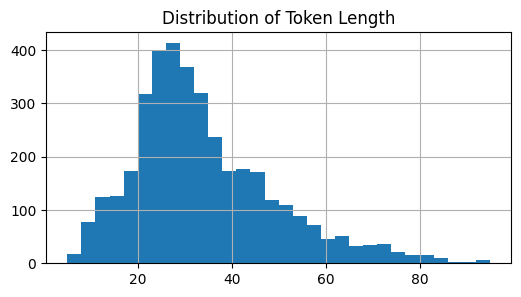

In [ ]:
plt.figure(figsize=(6, 3))
pd.Series([len(i) for i in ds_tkn_train['input_ids']]).hist(bins=30)
plt.title('Distribution of Token Length')
plt.show()

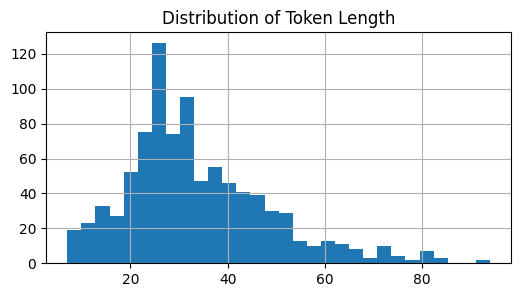

In [ ]:
plt.figure(figsize=(6, 3))
pd.Series([len(i) for i in ds_tkn_valid['input_ids']]).hist(bins=30)
plt.title('Distribution of Token Length')
plt.show()

In [ ]:
# textカラムの削除
ds_tkn_train = ds_tkn_train.remove_columns(['text'])
ds_tkn_valid = ds_tkn_valid.remove_columns(['text'])

# labelカラムをlabelsへリネーム
ds_tkn_train = ds_tkn_train.rename_column('label', 'labels')
ds_tkn_valid = ds_tkn_valid.rename_column('label', 'labels')

## モデル

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL,
                                                           num_labels=2)

## 学習

In [ ]:
trainer_args = TrainingArguments(
    seed=123,
    output_dir=".",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_steps=1e6, # saveのステップを大きくしてここではモデルの保存を行わないようにする
    log_level="critical",
    num_train_epochs=N_EPOCH,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=12,
    save_total_limit=1,
    fp16=True,
    remove_unused_columns=False,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer_args.train_batch_size, trainer_args.eval_batch_size

(8, 12)

In [ ]:
metric = evaluate.load("f1")
metric

EvaluationModule(name: "f1", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    labels (`list` of `int`): The set of labels to include when `average` is not set to `'binary'`, and the order of the labels if `average` is `None`. Labels present in the data can be excluded, for example to calculate a multiclass average ignoring a majority negative class. Labels not present in the data will result in 0 components in a macro average. For multilabel targets, labels are column indices. By default, all labels in `predictions` and `references` are used in sorted order. Defaults to None.
    pos_label (`int`): The class to be considered the positive class, in the case where `average` is set to `binary`. Defaults to 1.
    average (`string`): This parameter is required for multiclass/multilabel t

In [ ]:
metric.name

'f1'

In [ ]:
# 精度評価関数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# 精度評価関数
'''
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    result = f1_score(p.label_ids, preds)
    return {"f1_score":result}

'''

'\ndef compute_metrics(p: EvalPrediction):\n    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions\n    preds = np.argmax(preds, axis=1)\n    result = f1_score(p.label_ids, preds)\n    return {"f1_score":result}\n\n'

In [ ]:
trainer = Trainer(
    model=model,
    args=trainer_args,
    tokenizer=tokenizer,
    train_dataset=ds_tkn_train,
    eval_dataset=ds_tkn_valid,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

{'loss': 0.2311, 'grad_norm': 0.14129678905010223, 'learning_rate': 2.2531914893617024e-06, 'epoch': 1.0}
{'eval_loss': 0.14591790735721588, 'eval_f1': 0.26666666666666666, 'eval_runtime': 3.0649, 'eval_samples_per_second': 292.666, 'eval_steps_per_second': 24.47, 'epoch': 1.0}
{'loss': 0.1272, 'grad_norm': 77.39958190917969, 'learning_rate': 1.5047872340425533e-06, 'epoch': 2.0}
{'eval_loss': 0.2177233248949051, 'eval_f1': 0.4307692307692308, 'eval_runtime': 3.3308, 'eval_samples_per_second': 269.306, 'eval_steps_per_second': 22.517, 'epoch': 2.0}
{'loss': 0.0657, 'grad_norm': 1.2144027948379517, 'learning_rate': 7.547872340425532e-07, 'epoch': 3.0}
{'eval_loss': 0.15888230502605438, 'eval_f1': 0.673469387755102, 'eval_runtime': 3.2208, 'eval_samples_per_second': 278.506, 'eval_steps_per_second': 23.286, 'epoch': 3.0}
{'loss': 0.0368, 'grad_norm': 0.006867183372378349, 'learning_rate': 4.787234042553191e-09, 'epoch': 4.0}
{'eval_loss': 0.16860418021678925, 'eval_f1': 0.693069306930693

TrainOutput(global_step=1880, training_loss=0.1152257797565866, metrics={'train_runtime': 538.9779, 'train_samples_per_second': 27.897, 'train_steps_per_second': 3.488, 'train_loss': 0.1152257797565866, 'epoch': 4.0})

In [ ]:
trainer

## テストデータによる評価

In [ ]:
df_test = pd.read_csv('https://sample-data-open.s3.ap-northeast-1.amazonaws.com/text_classification_hatespeech/hatespeech_test.csv')
print(df_test.shape)
df_test.head()

(600, 4)


,id,source,text,label
0,e3d3e578b,news4vip,まぁ、俺の言ってることは余りあてにしないでくれwwww\n\n必ずいい人は現れるよ,0
1,a728f26db,news4vip,すまないがそれはレンジのほうか？\nそれともトースター？,0
2,c53e66dc9,livejupiter,そら大不況で独り勝ちした金持ちを殺してしかも自分もちゃんと腹切ってるからな\n今で言うならリ...,0
3,fb3b600fb,newsplus,外国や外国人に税金や公的資金を使うのは違法と言ってくれたら、民進党の支持率は爆上げだろうな。,0
4,ef9cd1326,newsplus,中国人は、日本の年金制度にものらないとw,0


In [ ]:
ds_test = datasets.Dataset.from_pandas(df_test[['text','label']], preserve_index=False)

In [ ]:
ds_tkn_test = ds_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
ds_tkn_test

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 600
})

In [ ]:
# textカラムの削除
ds_tkn_test = ds_tkn_test.remove_columns(['text'])

# labelカラムをlabelsへリネーム
ds_tkn_test = ds_tkn_test.rename_column('label', 'labels')

In [ ]:
test_preds = trainer.predict(ds_tkn_test)

In [ ]:
test_preds

PredictionOutput(predictions=array([[ 5.1953125, -4.6796875],
       [ 4.9257812, -4.640625 ],
       [ 4.9023438, -4.4257812],
       ...,
       [ 4.9921875, -4.6640625],
       [ 4.21875  , -3.96875  ],
       [ 5.1289062, -4.546875 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
    

In [ ]:
test_preds.metrics

{'test_loss': 0.25103455781936646,
 'test_f1': 0.611111111111111,
 'test_runtime': 2.0735,
 'test_samples_per_second': 289.365,
 'test_steps_per_second': 24.114}

In [ ]:
test_preds.predictions.shape

(600, 2)

In [ ]:
type(test_preds.predictions)

numpy.ndarray

In [ ]:
test_preds.predictions

array([[ 5.1953125, -4.6796875],
       [ 4.9257812, -4.640625 ],
       [ 4.9023438, -4.4257812],
       ...,
       [ 4.9921875, -4.6640625],
       [ 4.21875  , -3.96875  ],
       [ 5.1289062, -4.546875 ]], dtype=float32)